## Random Forest Hyperparameter Optimization
This notebook is part of a project to identify sentence complexity and includes all engineered features including LSA/K-means on Tfidf results and Word2Vec principal components and clusters.  The notebook includes the following:

- Load Data
- Run Baseline Random Forest Model
    - Generate F1 Scores
    - Generate Confusion Matrix
    - Generate Feature Importance Scores (via MDI)
    - Generate Feature Importance Socres (via permutation)
    - Show Initial Decision Tree Models in Ensemble 
- Use RandomizedSeachCV to Optimize Random Forest Model Hyperparameters
    - Generate F1 Scores
    - Generate Confusion Matrix
    - Generate Feature Importance Scores (via MDI)
    - Generate Feature Importance Scores (via permutation)
    - Full Results from RandomizedSearchCV

In [1]:
#import needed libraries
import gzip
import pandas as pd
import numpy as np
from numpy import nan

import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn import tree

from tqdm import tqdm
import time
import sys
import os

#set random seed for consistency
RANDOM_SEED = 694

## Load Data

In [36]:
#load data prepared from feature engineering
df_train=pd.read_csv('Train_Data_Final.csv')
df_test=pd.read_csv('Test_Data_Final.csv')
df_dev=pd.read_csv('Dev_Data_Final.csv')

In [37]:
#get data discovered using LSA/K-means
df_train_lsa=pd.read_csv('Train_LSA_Kmeans.csv')
df_test_lsa=pd.read_csv('Test_LSA_Kmeans.csv')
df_dev_lsa=pd.read_csv('Dev_LSA_Kmeans.csv')

#get data discovered using Word2Vec
df_train_w2v=pd.read_csv('Train_Word2Vec.csv')
df_test_w2v=pd.read_csv('Test_Word2Vec.csv')
df_dev_w2v=pd.read_csv('Dev_Word2Vec.csv')

In [38]:
#add features to dataframes
lsa_cols = df_train_lsa.columns[3:]
w2v_cols = df_train_w2v.columns[3:]

#add LSA/K-means features
df_train[lsa_cols] = df_train_lsa[lsa_cols]
df_test[lsa_cols] = df_test_lsa[lsa_cols]
df_dev[lsa_cols] = df_dev_lsa[lsa_cols]

#add Word2Vec features
df_train[w2v_cols] = df_train_w2v[w2v_cols]
df_test[w2v_cols] = df_test_w2v[w2v_cols]
df_dev[w2v_cols] = df_dev_w2v[w2v_cols]

## Set Train/Test Data

In [39]:
#remove index and data label
X_train=df_train.drop(columns=['Unnamed: 0','label'])._get_numeric_data()
X_test=df_test.drop(columns=['Unnamed: 0','label'])._get_numeric_data()
X_dev=df_dev.drop(columns=['Unnamed: 0','label'])._get_numeric_data()

In [40]:
#correct for infinity and nan 
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train=X_train.fillna(-1)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test=X_test.fillna(-1)
X_dev.replace([np.inf, -np.inf], np.nan, inplace=True)
X_dev=X_dev.fillna(-1)

In [41]:
#assign labels
y_train = df_train['label']
y_test = df_test['label']
y_dev = df_dev['label']

## Random Forest

In [23]:
%%time
#train RF model
rf_clf=RandomForestClassifier(max_depth=10,n_jobs=-1,n_estimators=20,random_state=RANDOM_SEED)
rf_clf.fit(X_train,y_train)

CPU times: user 51.1 s, sys: 605 ms, total: 51.7 s
Wall time: 13.5 s


RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=694)

In [24]:
#calculate F1 scores
recall_train=f1_score(y_train,rf_clf.predict(X_train))
recall_test=f1_score(y_test,rf_clf.predict(X_test))
recall_dev=f1_score(y_dev,rf_clf.predict(X_dev))
print('recall_train:',recall_train)
print('recall_test:',recall_test)
print('recall_dev:',recall_dev)

#previous scores without supplemental features (LSA, K-means, Word2Vec)
#f1_train: 0.7416327093998115
#f1_test: 0.7132636213538801
#f1_dev: 0.7198433358011128

recall_train: 0.7127001265484774
recall_test: 0.7002758269012355
recall_dev: 0.7033495033495033


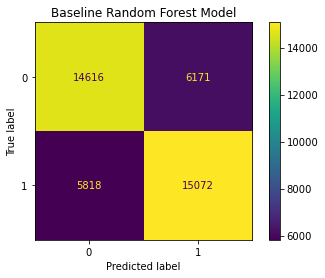

In [71]:
#generate confustion matrix
cm=confusion_matrix(y_test, rf_clf.predict(X_test),labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()
disp.ax_.set_title('Baseline Random Forest Model');

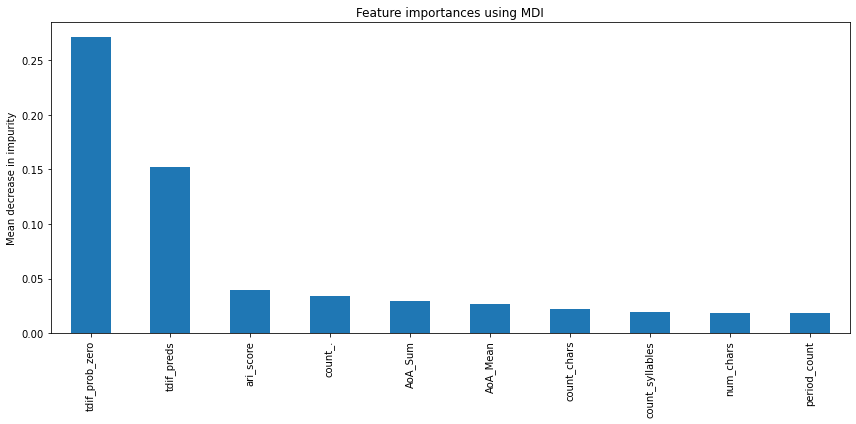

In [28]:
#feature importance using MDI, plot results
feature_names = list(X_train.columns)

importances= pd.Series(rf_clf.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))

importances.sort_values(ascending=False)[0:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
%%time
#feature importance using permutations
result = permutation_importance(rf_clf, X_dev, y_dev, n_repeats=10, 
                                random_state=RANDOM_SEED, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=[X_dev.columns])

CPU times: user 2.62 s, sys: 254 ms, total: 2.87 s
Wall time: 1min 29s


In [19]:
#sort by most important features
top_sorted_forest_importances = forest_importances.sort_values(axis=0, ascending=False)

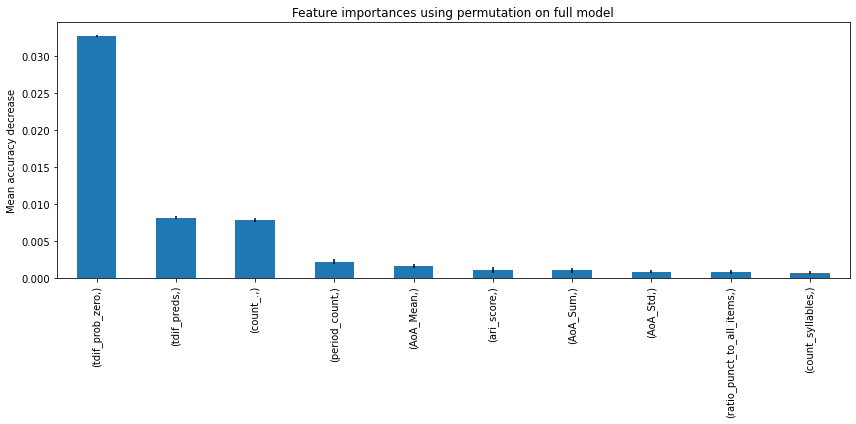

In [30]:
#plot results
fig, ax = plt.subplots(figsize=(12,6))
top_sorted_forest_importances[0:10].plot.bar(yerr=result.importances_std[0:10], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

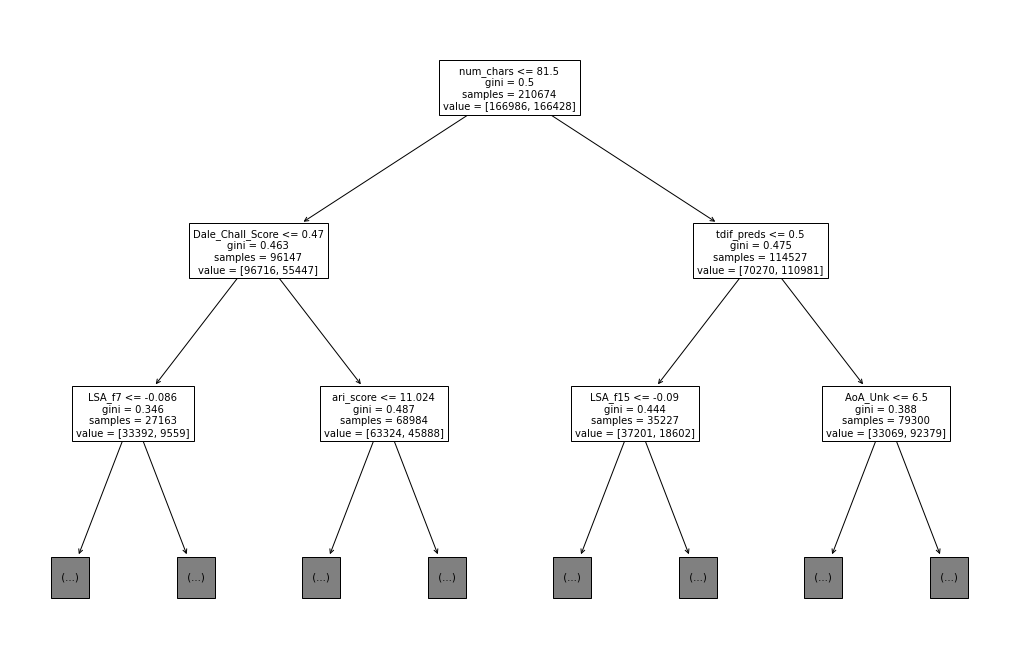

In [21]:
#plot first decision tree in random forest
plt.figure(figsize=(18,12)) 
tree.plot_tree(rf_clf.estimators_[0], feature_names=X_dev.columns, fontsize=10, max_depth=2)
plt.show()


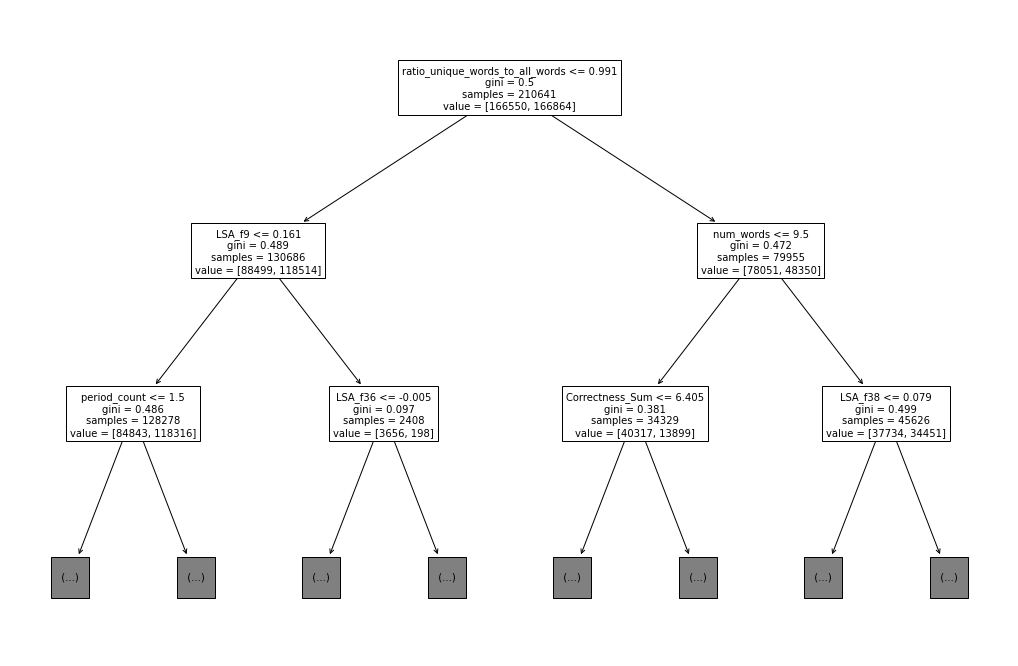

In [22]:
#plot second decision tree in random forest
plt.figure(figsize=(18,12)) 
tree.plot_tree(rf_clf.estimators_[1], feature_names=X_dev.columns, fontsize=10, max_depth=2)
plt.show()

## Random Forest Hyperparamter Tuning

In [23]:
#show current paramters being used
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 694,
 'verbose': 0,
 'warm_start': False}

In [15]:
#create grid parameters
#n_estimators = [30, 40, 50]
#max_features = ['auto']
#max_depth = [30, 40, 50]
#min_samples_split = [4, 6]
#min_samples_leaf = [1, 2]
#bootstrap = [True]
n_estimators = [50]
max_features = ['auto']
max_depth = [30]
min_samples_split = [4]
min_samples_leaf = [2]
bootstrap = [True]

In [16]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [50],
 'max_features': ['auto'],
 'max_depth': [30],
 'min_samples_split': [4],
 'min_samples_leaf': [2],
 'bootstrap': [True]}

In [42]:
rf = RandomForestClassifier(random_state = RANDOM_SEED)

In [43]:
%%time
#run optimizer using RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, n_iter = 10, 
                               cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3min 59s, sys: 999 ms, total: 4min
Wall time: 6min 36s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=694),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True], 'max_depth': [30],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2],
                                        'min_samples_split': [4],
                                        'n_estimators': [50]},
                   random_state=694, verbose=2)

In [44]:
#best parameter from tuning
rf_random.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 694,
 'verbose': 0,
 'warm_start': False}

In [45]:
#calculate F1 scores
recall_train_rand=recall_score(y_train,rf_random.predict(X_train))
recall_test_rand=recall_score(y_test,rf_random.predict(X_test))
recall_dev_rand=recall_score(y_dev,rf_random.predict(X_dev))
print('recall_train_rand:',recall_train_rand)
print('recall_test_rand:',recall_test_rand)
print('recall_dev_rand:',recall_dev_rand)

#scores including tf-idf predictors
#recall_train_rand: 0.9813807430890794
#recall_test_rand: 0.7558640497845859
#recall_dev_rand: 0.7591425570514657

recall_train_rand: 0.9813807430890794
recall_test_rand: 0.7558640497845859
recall_dev_rand: 0.7591425570514657


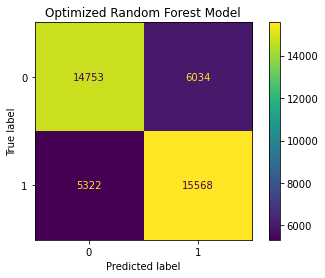

In [21]:
#generate confustion matrix
cm=confusion_matrix(y_test, rf_random.predict(X_test),labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_random.classes_)
disp.plot()
disp.ax_.set_title('Optimized Random Forest Model');

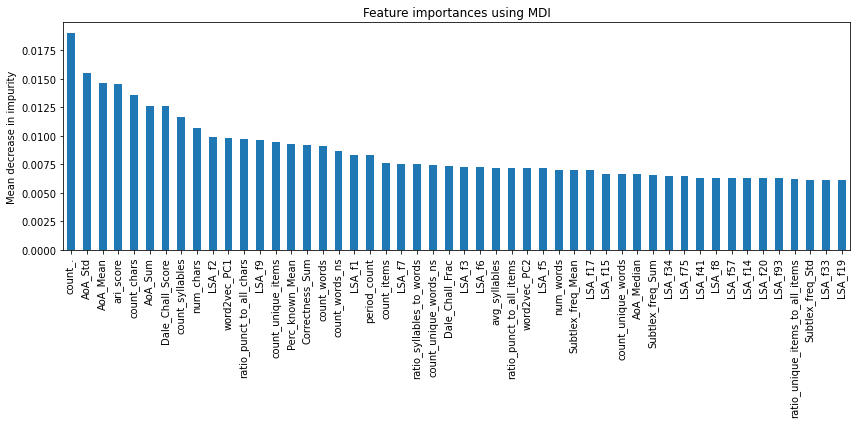

In [35]:
#feature importance using MDI, plot results (without tf-idf predictors)
feature_names = list(X_train.columns)

importances= pd.Series(rf_random.best_estimator_.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))

importances.sort_values(ascending=False)[0:50].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

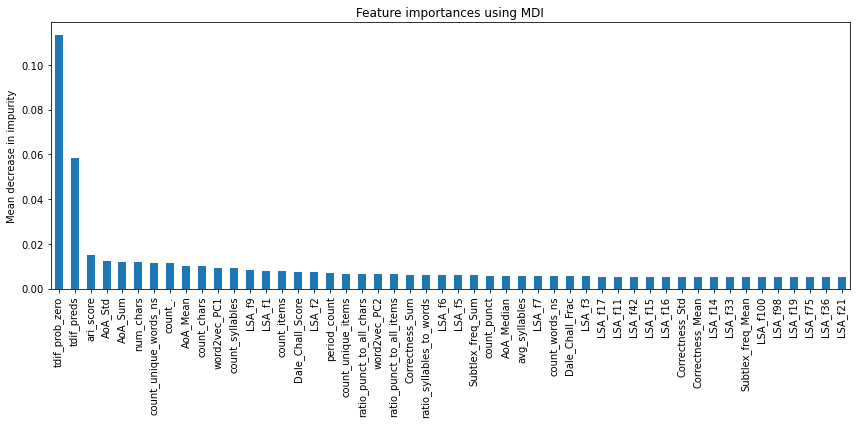

In [48]:
#feature importance using MDI, plot results (with tf-idf predictors)
feature_names = list(X_train.columns)

importances= pd.Series(rf_random.best_estimator_.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))

importances.sort_values(ascending=False)[0:50].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [51]:
#top 10 features using MDI
importances.sort_values(ascending=False)[0:60]

tdif_prob_zero              0.113264
tdif_preds                  0.058572
ari_score                   0.014819
AoA_Std                     0.012365
AoA_Sum                     0.011964
num_chars                   0.011814
count_unique_words_ns       0.011654
count_.                     0.011601
AoA_Mean                    0.010187
count_chars                 0.010124
word2vec_PC1                0.009411
count_syllables             0.009054
LSA_f9                      0.008229
LSA_f1                      0.008049
count_items                 0.007999
Dale_Chall_Score            0.007550
LSA_f2                      0.007303
period_count                0.007072
count_unique_items          0.006773
ratio_punct_to_all_chars    0.006725
word2vec_PC2                0.006587
ratio_punct_to_all_items    0.006367
Correctness_Sum             0.006321
ratio_syllables_to_words    0.006280
LSA_f6                      0.006127
LSA_f5                      0.005963
Subtlex_freq_Sum            0.005886
c

In [41]:
%%time
#feature importance using permutations
result = permutation_importance(rf_random, X_dev, y_dev, n_repeats=10, random_state=RANDOM_SEED)
forest_importances = pd.Series(result.importances_mean, index=[X_dev.columns])

CPU times: user 33min 28s, sys: 35.5 s, total: 34min 4s
Wall time: 34min 4s


In [42]:
top_sorted_forest_importances = forest_importances.sort_values(axis=0, ascending=False)

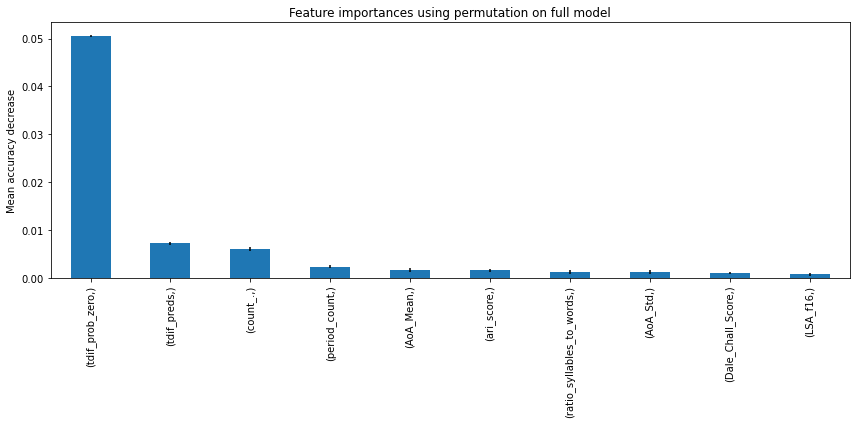

In [49]:
#plot results
fig, ax = plt.subplots(figsize=(12,6))
top_sorted_forest_importances[0:10].plot.bar(yerr=result.importances_std[0:10], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [44]:
#top 10 features using permutations
top_sorted_forest_importances[0:10]

tdif_prob_zero              0.050591
tdif_preds                  0.007203
count_.                     0.006058
period_count                0.002294
AoA_Mean                    0.001608
ari_score                   0.001531
ratio_syllables_to_words    0.001284
AoA_Std                     0.001197
Dale_Chall_Score            0.000967
LSA_f16                     0.000701
dtype: float64

In [45]:
#investigate results from random search
full_results = pd.DataFrame(rf_random.cv_results_)[['params', 'mean_test_score','rank_test_score']]
with pd.option_context('display.max_colwidth', None):
    display(full_results.sort_values(by=['rank_test_score']))

,params,mean_test_score,rank_test_score
1,"{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}",0.756855,1
9,"{'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}",0.756090,2
5,"{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}",0.755514,3
8,"{'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}",0.755418,4
2,"{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}",0.754410,5
0,"{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}",0.753892,6
6,"{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}",0.753805,7
4,"{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}",0.753577,8
7,"{'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}",0.753097,9
3,"{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}",0.751063,10


In [50]:
#test for optimal recall_estimators
max_features = ['auto']
max_depth = [30]
min_samples_split = [4]
min_samples_leaf = [2]
bootstrap = [True]
test_recall= []
recall_estimators = [10,20,30,40,50,60,70,80]

for i in recall_estimators:
    n_estimators = [i]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, n_iter = 1, 
                               cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)

    rf_random.fit(X_train, y_train)
    test_recall.append(recall_score(y_test,rf_random.predict(X_test)))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Text(0.5, 1.0, 'Test recall socre with increased random forest estimators')

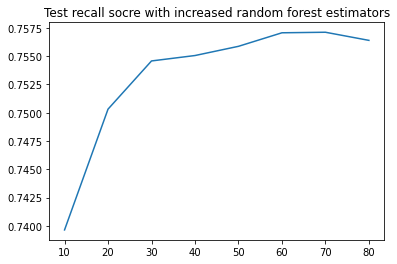

In [77]:
#plot results
plt.plot(recall_estimators, test_recall);
plt.title('Test recall socre with increased random forest estimators')